In [1]:
# !gdown 1-71hYGVEWoJH3JTtH9CAsSQ6PotpiZBW

In [1]:
import os
import cv2
import shutil
import secrets
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Sequential, Model
from keras import optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from PIL import ImageFile
import seaborn as sns
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.applications.alexnet import AlexNet, preprocess_input

In [2]:
PARENT_PATH = os.getcwd()
DATA_PATH = os.path.join(os.getcwd(),"CombinedNew", "Combined New")
TEST_PATH = os.path.join(DATA_PATH, "test")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
NEW_TRAIN_PATH = os.path.join(DATA_PATH, "new_train")
VALID_PATH = os.path.join(DATA_PATH, "valid")
UNSEEN_PATH = os.path.join(DATA_PATH, "unseen")
MODEL_PATH = "drive/MyDrive/models"
NUM_CLASSES = 8

In [3]:
if os.path.exists(DATA_PATH):
  shutil.rmtree(DATA_PATH)
from zipfile import ZipFile
password = "57Rk!F8yUz38"
with ZipFile('drive/MyDrive/CombinedNew.zip') as zipObj:
  zipObj.extractall()

In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
NUM_EPOCH = 30

In [5]:
for class_folder in os.listdir(TRAIN_PATH):
  class_path = os.path.join(TRAIN_PATH, class_folder)
  if class_folder == ".DS_Store":
      continue
  train_imgs, test_imgs = train_test_split(os.listdir(class_path), test_size=0.2, random_state = 42)

  for img in train_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(NEW_TRAIN_PATH, class_folder, img)
    if not os.path.exists(os.path.join(NEW_TRAIN_PATH, class_folder)):
      os.makedirs(os.path.join(NEW_TRAIN_PATH, class_folder))
    shutil.copy(src, dst)

  for img in test_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(VALID_PATH, class_folder, img)
    if not os.path.exists(os.path.join(VALID_PATH, class_folder)):
      os.makedirs(os.path.join(VALID_PATH, class_folder))
    shutil.copy(src, dst)

In [6]:
def create_df(DATA_PATH):
  cls_names = os.listdir(DATA_PATH)
  data = []
  for cls in cls_names: 
    if cls == ".DS_Store":
      continue
    cls_path = os.path.join(DATA_PATH, cls)
    print(cls_path)
    for file in os.listdir(cls_path):
      data.append({"Filename": os.path.join(cls, file), "Class": cls})
  df = pd.DataFrame(data)
  return df
  
train_df = create_df(NEW_TRAIN_PATH)
valid_df = create_df(VALID_PATH)
test_df = create_df(TEST_PATH)

/content/CombinedNew/Combined New/new_train/c2
/content/CombinedNew/Combined New/new_train/c7
/content/CombinedNew/Combined New/new_train/c3
/content/CombinedNew/Combined New/new_train/c4
/content/CombinedNew/Combined New/new_train/c1
/content/CombinedNew/Combined New/new_train/c6
/content/CombinedNew/Combined New/new_train/c5
/content/CombinedNew/Combined New/new_train/c0
/content/CombinedNew/Combined New/valid/c2
/content/CombinedNew/Combined New/valid/c7
/content/CombinedNew/Combined New/valid/c3
/content/CombinedNew/Combined New/valid/c4
/content/CombinedNew/Combined New/valid/c1
/content/CombinedNew/Combined New/valid/c6
/content/CombinedNew/Combined New/valid/c5
/content/CombinedNew/Combined New/valid/c0
/content/CombinedNew/Combined New/test/c2
/content/CombinedNew/Combined New/test/c7
/content/CombinedNew/Combined New/test/c3
/content/CombinedNew/Combined New/test/c4
/content/CombinedNew/Combined New/test/c1
/content/CombinedNew/Combined New/test/c6
/content/CombinedNew/Combine

<Axes: >

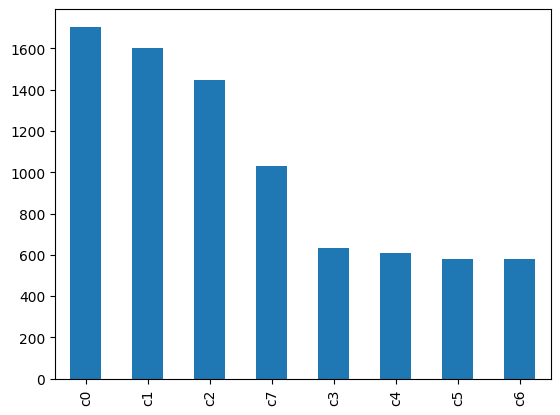

In [7]:
train_df['Class'].value_counts().plot.bar()

<Axes: >

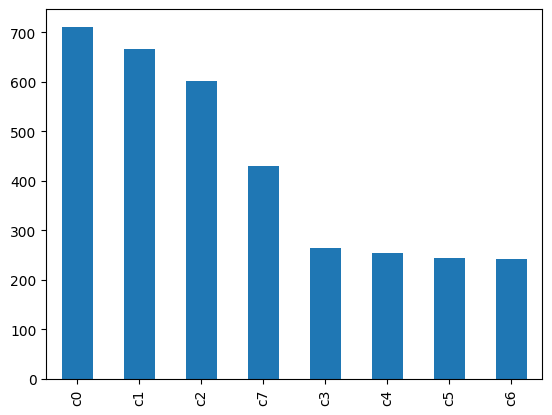

In [8]:
test_df['Class'].value_counts().plot.bar()

In [9]:
rotation_range = 5
width_shift_range = 0.01
height_shift_range = 0.01
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
verticle_flip = False
fill_mode = "nearest"

The preprocess_input function resize the image to 299x299 pixels, which was chosen base on the architecture of the InceptionV3 models, so we do not need to resize it anymore

In [10]:
# for inc
train_datagen = ImageDataGenerator(
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        zoom_range = zoom_range,
        fill_mode = fill_mode,
        validation_split = 0.2,
        preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(
        validation_split = 0.2,
        preprocessing_function = preprocess_input
)

train_data = train_datagen.flow_from_directory(NEW_TRAIN_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

valid_data = test_datagen.flow_from_directory(VALID_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)
test_data = test_datagen.flow_from_directory(TEST_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
unseen_data = test_datagen.flow_from_directory(UNSEEN_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

Found 8176 images belonging to 8 classes.
Found 2049 images belonging to 8 classes.
Found 3414 images belonging to 8 classes.
Found 839 images belonging to 8 classes.


In [11]:
classes = [i for i in range(8)]
print(classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_data.classes)
class_weights = dict(enumerate(class_weights.flatten(), 0))
print(class_weights)

[0, 1, 2, 3, 4, 5, 6, 7]
{0: 0.5997652582159625, 1: 0.63875, 2: 0.7077562326869806, 3: 1.6170886075949367, 4: 1.6781609195402298, 5: 1.7620689655172415, 6: 1.768166089965398, 7: 0.9931972789115646}


In [12]:
base_model_inc = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

for layer in base_model_inc.layers:
    layer.trainable = True

87910968/87910968 [==============================] - 3s 0us/step


In [13]:
top_models_inc = Sequential()
top_models_inc.add(GlobalAveragePooling2D(input_shape=base_model_inc.output_shape[1:]))
top_models_inc.add(Dense(256, activation='relu', kernel_initializer='glorot_normal'))
top_models_inc.add(Dropout(0.5))
top_models_inc.add(Dense(8, activation='softmax', kernel_initializer='glorot_normal'))
top_models_inc = Model(inputs = base_model_inc.input, outputs = top_models_inc(base_model_inc.output))

top_models_inc.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0002, momentum=0.9)
top_models_inc.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [15]:
filepath = os.path.join(MODEL_PATH, "distracted-inception_dropout_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max',period=1)
early_stopping = early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [early_stopping, checkpoint]

In [17]:
model_history_inc = top_models_inc.fit(train_data,
                                       validation_data=valid_data,
                                       epochs=NUM_EPOCH, 
                                       shuffle=True,
                                       callbacks=callbacks_list, 
                                       class_weight=class_weights)


Epoch 1/30
128/128 [==============================] - ETA: 0s - loss: 2.1909 - accuracy: 0.1610
Epoch 1: val_accuracy improved from -inf to 0.18643, saving model to drive/MyDrive/models/distracted-inception_dropout_best.hdf5
128/128 [==============================] - 377s 3s/step - loss: 2.1909 - accuracy: 0.1610 - val_loss: 2.0652 - val_accuracy: 0.1864
Epoch 2/30
128/128 [==============================] - ETA: 0s - loss: 1.9926 - accuracy: 0.2369
Epoch 2: val_accuracy improved from 0.18643 to 0.38067, saving model to drive/MyDrive/models/distracted-inception_dropout_best.hdf5
128/128 [==============================] - 301s 2s/step - loss: 1.9926 - accuracy: 0.2369 - val_loss: 1.8335 - val_accuracy: 0.3807
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 1.8227 - accuracy: 0.3307
Epoch 3: val_accuracy improved from 0.38067 to 0.49683, saving model to drive/MyDrive/models/distracted-inception_dropout_best.hdf5
128/128 [==============================] - 300s 2s/step

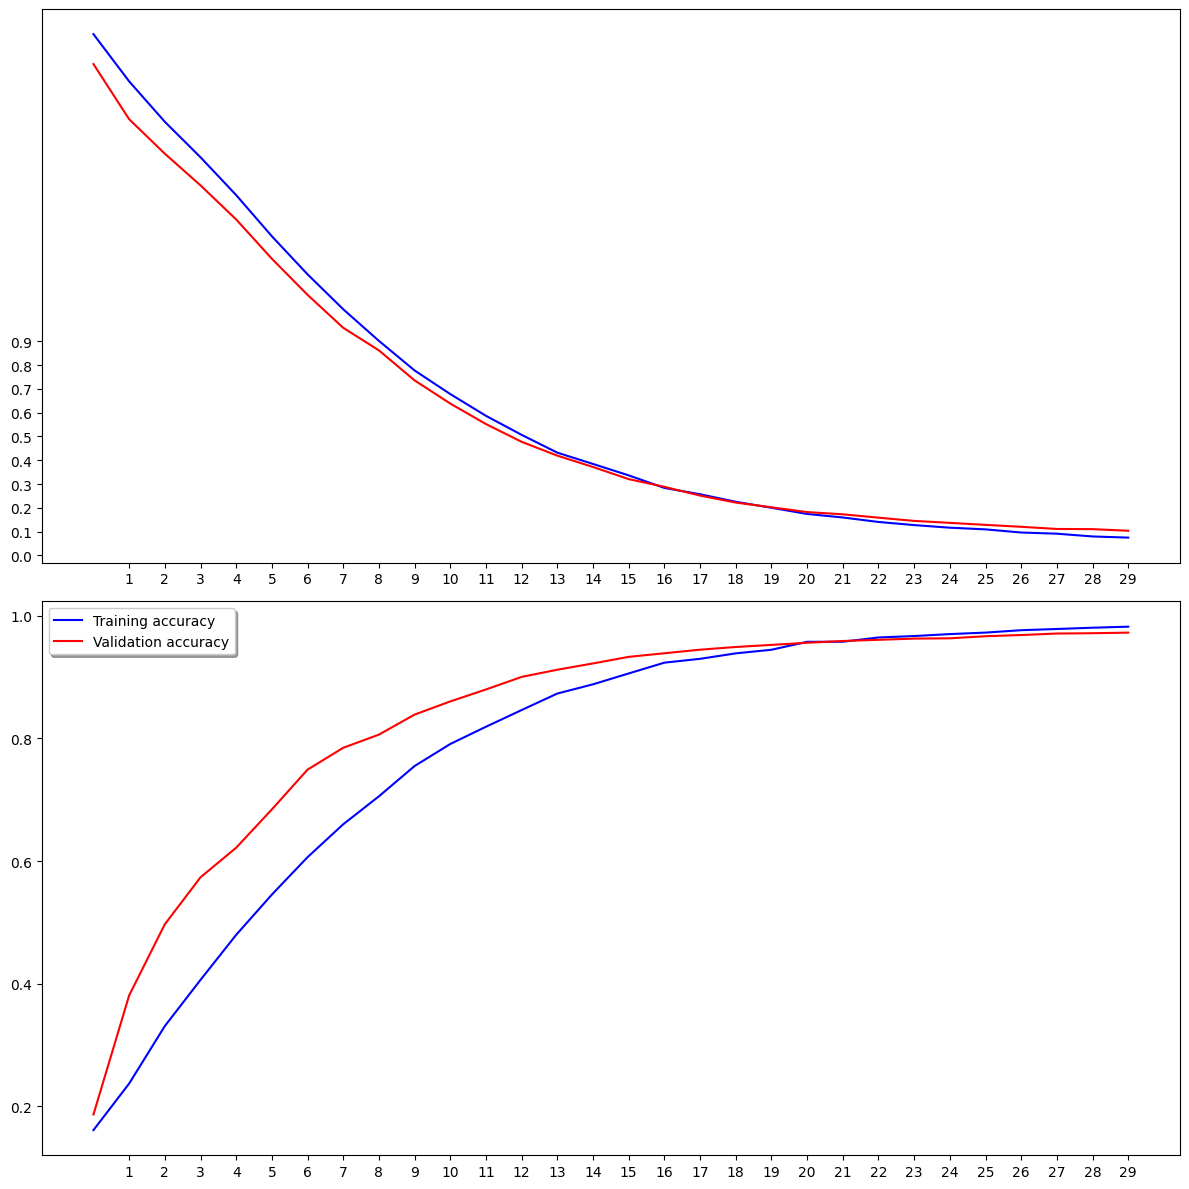

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history_inc.history['loss'], color='b', label="Training loss")
ax1.plot(model_history_inc.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history_inc.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history_inc.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [16]:
top_models_inc.load_weights('drive/MyDrive/models/distracted-inception_dropout_best.hdf5')

In [20]:
print(top_models_inc)

In [21]:
# evaluate_data = datagen.flow_from_directory(UNSEEN_DATA,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=BATCH_SIZE,shuffle=False)

In [22]:
ypred = top_models_inc.predict(test_data)
print(ypred)
evaluate_list = test_data.classes.tolist()
ypred_class = np.argmax(ypred,axis=1)
print(ypred_class)
ytest = evaluate_list
print(ytest)

54/54 [==============================] - 71s 1s/step
[[9.0456742e-01 3.6874585e-02 2.7675496e-02 ... 8.0761180e-04
  4.3148980e-03 1.9368073e-02]
 [9.9567270e-01 2.4618867e-03 5.4252753e-04 ... 1.6892550e-04
  2.7869229e-04 3.3185570e-04]
 [9.6427631e-01 2.5138881e-02 6.6014701e-03 ... 5.0290808e-04
  7.8014552e-04 1.3069994e-03]
 ...
 [2.5393799e-02 8.7205563e-03 5.7102158e-03 ... 4.1063731e-03
  8.5957065e-02 8.6407238e-01]
 [1.4737807e-03 2.6164337e-03 1.8011990e-03 ... 1.3376698e-03
  3.6530711e-03 9.8865640e-01]
 [1.2506876e-02 3.2466881e-02 8.5465349e-03 ... 9.2168078e-02
  1.8071597e-02 8.3248192e-01]]
[0 0 0 ... 7 7 7]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [23]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.977153
Precision: 0.977356
Recall: 0.977153
F1 score: 0.977034


In [24]:
top_models_inc.evaluate(test_data)

54/54 [==============================] - 69s 1s/step - loss: 0.0907 - accuracy: 0.9772


[0.0906849056482315, 0.9771528840065002]

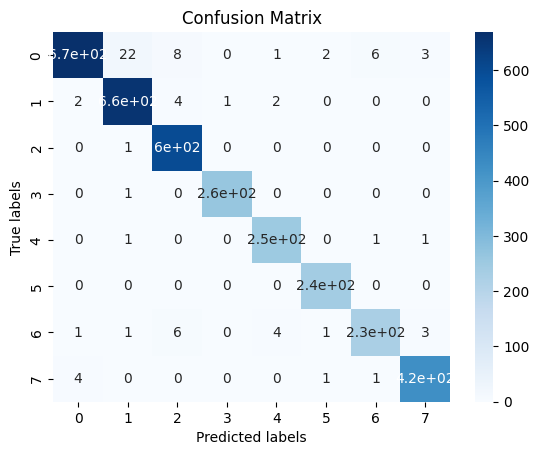

In [25]:
cm = confusion_matrix(ytest, ypred_class)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [26]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels,predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [27]:
class_names = list()
for name,idx in valid_data.class_indices.items():
    class_names.append(name)
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']


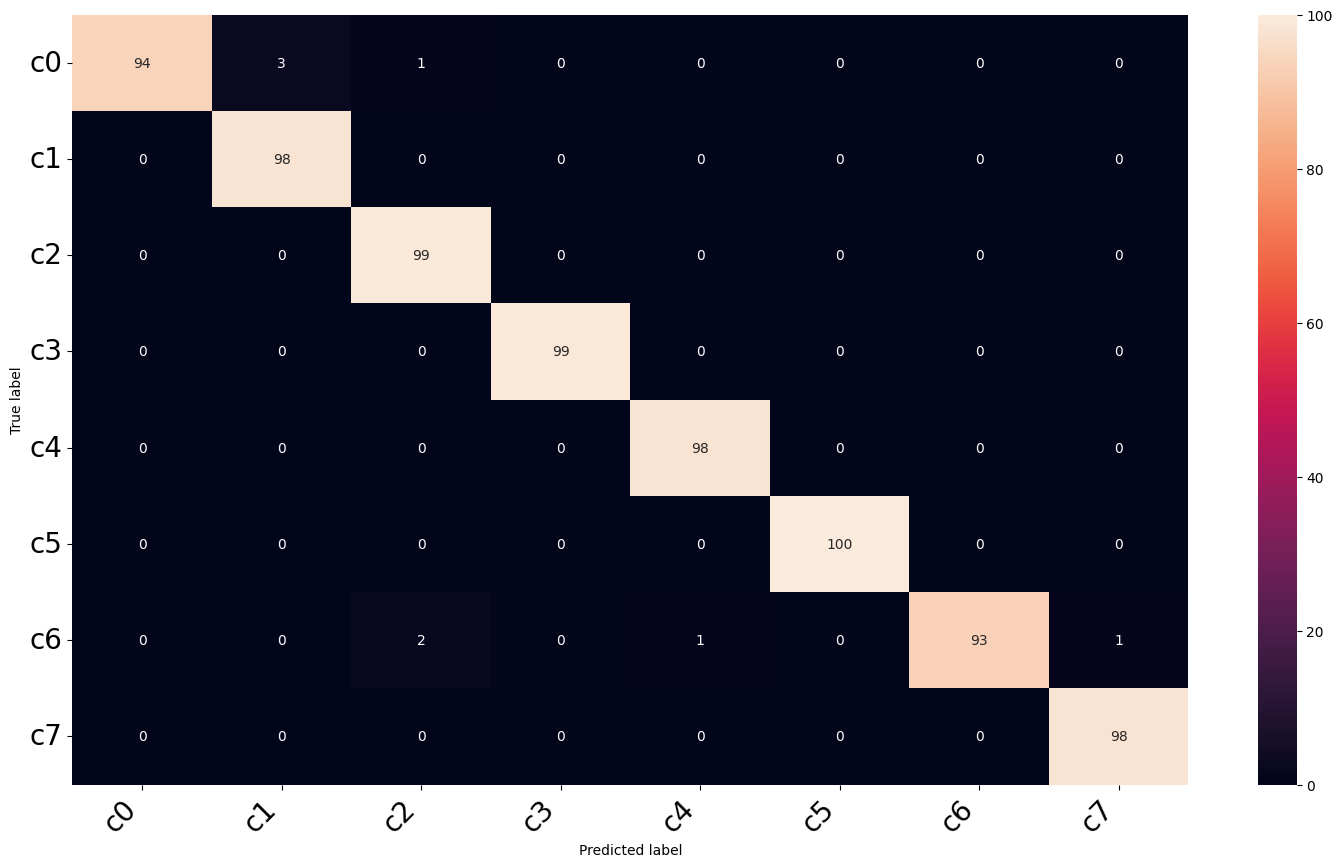

In [28]:
print_heatmap(ytest,ypred,class_names)

In [17]:
ypred = top_models_inc.predict(unseen_data)
print(ypred)
evaluate_list = unseen_data.classes.tolist()
ypred_class = np.argmax(ypred,axis=1)
print(ypred_class)
ytest = evaluate_list
print(ytest)

14/14 [==============================] - 29s 1s/step
[[7.3927872e-02 8.7774709e-02 1.6240531e-01 ... 1.8133821e-01
  2.3652989e-01 1.6978174e-01]
 [1.1434775e-01 6.8337485e-02 2.4626218e-01 ... 9.6497327e-02
  2.9069793e-01 1.1847221e-01]
 [4.6092875e-02 1.0369929e-01 9.1871507e-02 ... 4.7469229e-01
  3.3117771e-02 2.0136715e-01]
 ...
 [3.1500799e-03 7.2420057e-04 3.4209758e-03 ... 9.7494787e-03
  4.1518984e-03 9.7710836e-01]
 [5.5134967e-03 4.4331667e-03 2.5393001e-03 ... 8.2162777e-03
  4.4800569e-03 9.7110087e-01]
 [3.6852176e-03 5.7624653e-04 2.0859870e-03 ... 2.7371317e-03
  2.6378450e-03 9.8729813e-01]]
[6 6 5 0 0 0 0 0 0 6 6 6 6 7 6 6 6 6 6 6 6 6 7 7 7 5 2 6 2 2 6 5 5 5 2 5 5
 5 5 5 5 5 5 5 6 6 1 1 1 6 6 6 2 6 6 6 0 0 6 6 6 1 6 6 6 1 6 6 6 1 1 7 1 1
 1 1 1 1 0 0 1 1 7 6 1 1 4 1 1 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 2 2 1 1 0 0 0 0 0 2 2 0 1 0 0 0 0 2 2 1 2 1 2 0 0 0 0 0 0 1 7 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5
 1 1 1 5

In [18]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')

Accuracy: 0.601907
Precision: 0.633388
Recall: 0.601907


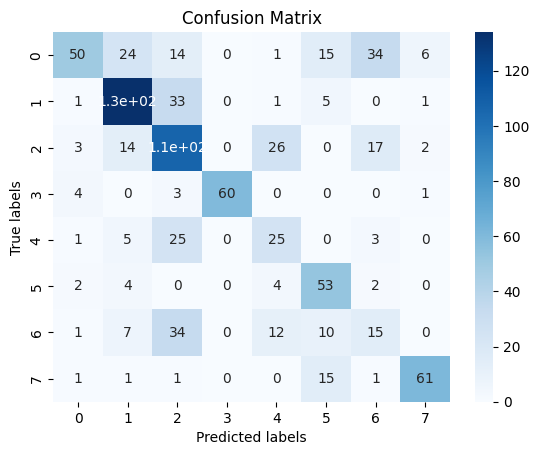

In [19]:
cm = confusion_matrix(ytest, ypred_class)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()